In [1]:
import numpy as np

import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube

from fusecam.aiutil import train_scripts
from fusecam.aiutil import ensembling

import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d
from dlsia.core import helpers
from dlsia.viz_tools import draw_sparse_network


import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [2]:
MATERIAL = "VEQC" #"VEQI" # "VEQF", "VEQM"
SIGMA_LOW = 3.0 # 3.0
N_PLANES = 20 # 10
SEM_NOISE = 0.00 # 0.1

_TOMO_NOISE = 0.00
_SIGMA_GT  = 0.5
_SEED = 121212

In [3]:
scale = 64
border = 15
radius = 10
sigma_low = SIGMA_LOW
sigma_high = _SIGMA_GT

In [4]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=0.80, seed=_SEED)
_, instance_map_0, class_map_0 = obj.fill()

/tmp/ipykernel_208108/2568210724.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 3)


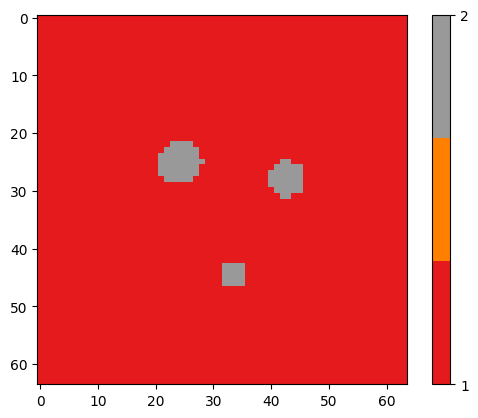

In [5]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[scale//2,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [6]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

In [7]:
#if MATERIAL == "VEQI":
#    elems = ["Si", "Fe"]
print(MATERIAL)
low_map, _, _ = mm3d.build_material_maps_XCT_SEM_EDX(class_map_low, MATERIAL)
xct_high_ref, high_map, elements = mm3d.build_material_maps_XCT_SEM_EDX(class_map_high, MATERIAL)
print(elements)

VEQC
['Si', 'Ca', 'Fe', 'Al']


In [8]:
print(high_map.shape, low_map.shape)

(4, 64, 64, 64) (1, 64, 64, 64)


In [9]:
low_map = low_map + mm3d.noise(low_map, _TOMO_NOISE, 0.0)
high_map = high_map + mm3d.noise(high_map, SEM_NOISE, 0.0)

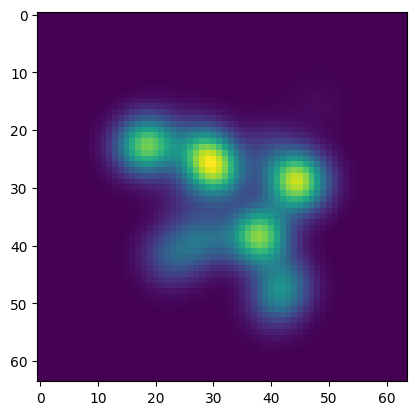

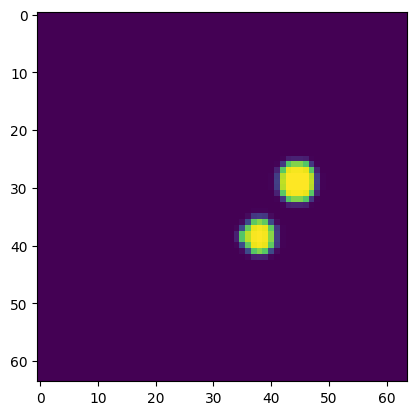

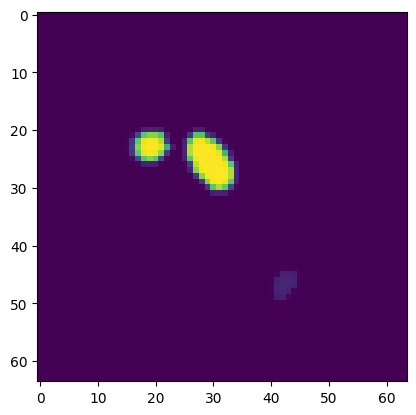

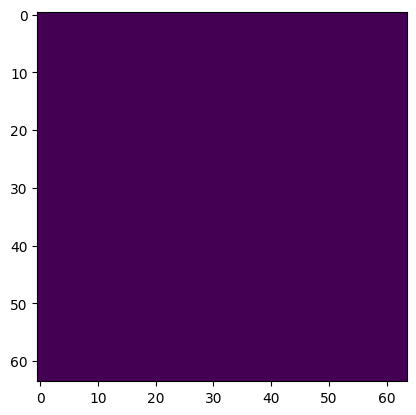

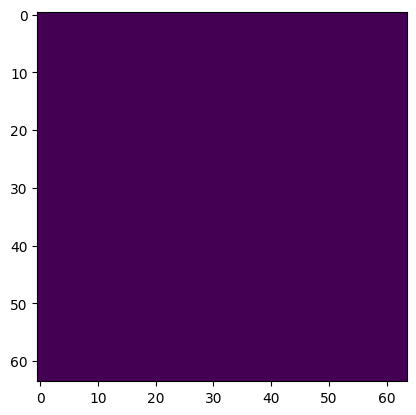

In [10]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[1, :,:,scale//2])
plt.show()

plt.imshow(high_map[2, :,:,scale//2])
plt.show()

plt.imshow(high_map[3, :,:,scale//2])
plt.show()



Now that we have data, I will use have to make the geometric objects

In [11]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [12]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T
print(UV.shape, XYZ.shape)

torch.Size([4096, 2]) torch.Size([262144, 3])


In [13]:
normal = np.array([0.2, 0.2, 1.0])
locations = np.linspace(scale//2-scale//3, scale//2+scale//3,N_PLANES+2)[1:-1]
print("plane locations", locations)
flat_high_map = einops.rearrange( torch.Tensor(high_map), "C X Y Z -> (X Y Z) C ")
flat_low_map = einops.rearrange( torch.Tensor(low_map), "C X Y Z -> (X Y Z) C ")
flat_xct_ref = einops.rearrange( torch.Tensor(xct_high_ref), "C X Y Z -> (X Y Z) C ")


plane locations [13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47.
 49. 51.]


Below we use interpolation to construc the cut plane with SEM-EDX data and the corresponding XCT data.
The same interpolation tables are used.

We don't need the interpolation tables, as we will work directly against the images in this case.

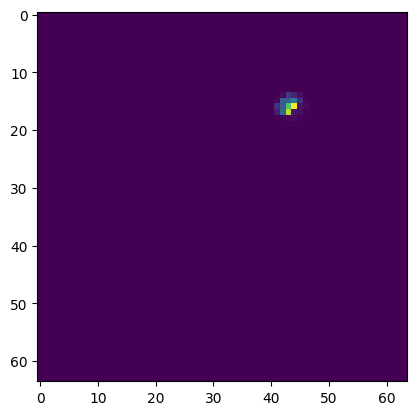

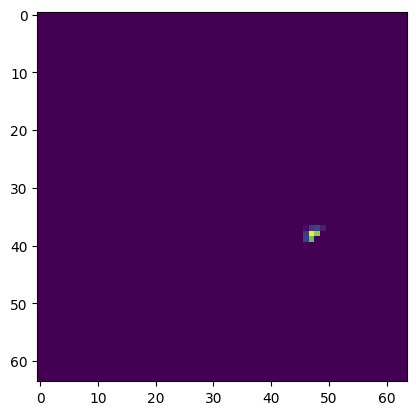

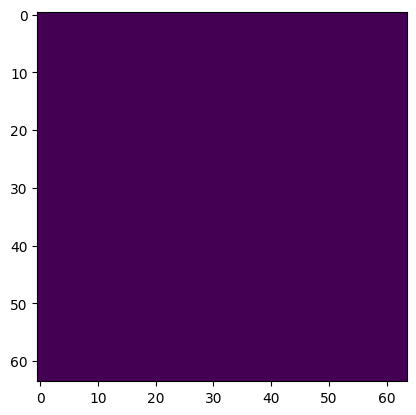

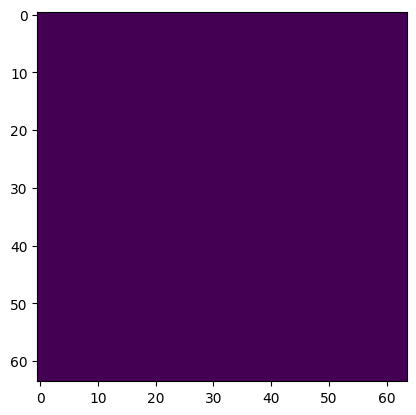

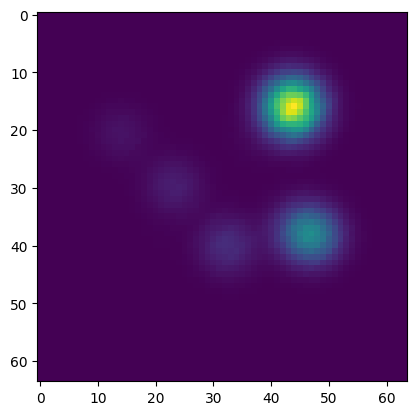

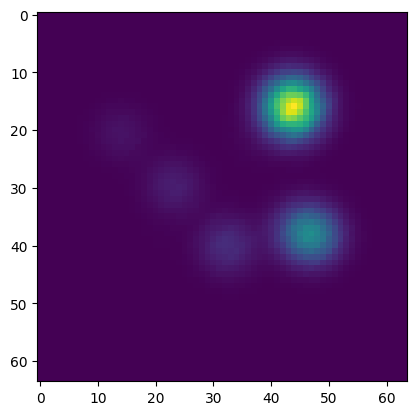

--------------------------


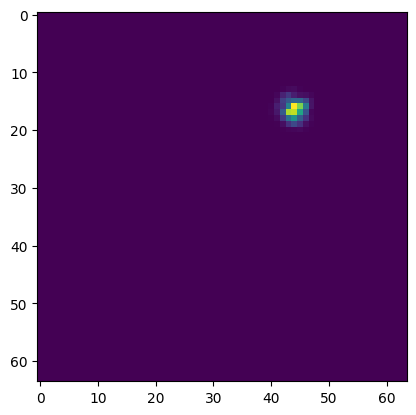

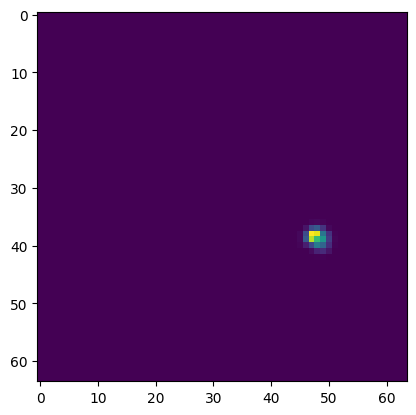

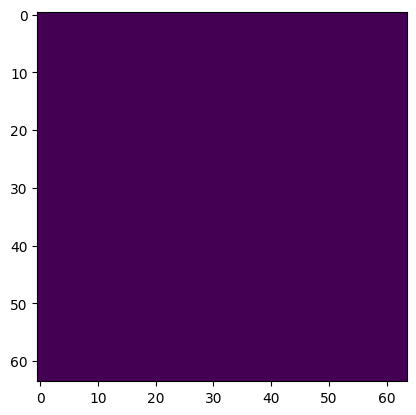

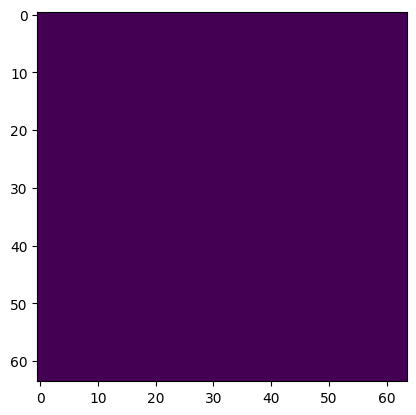

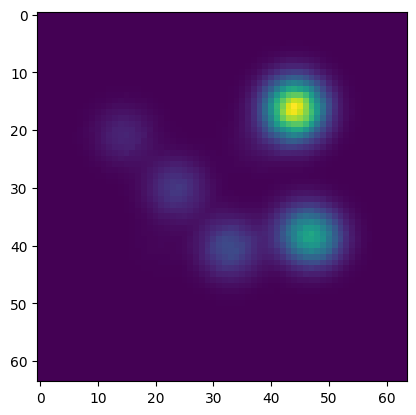

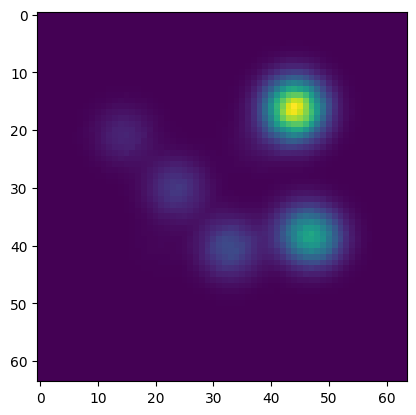

--------------------------


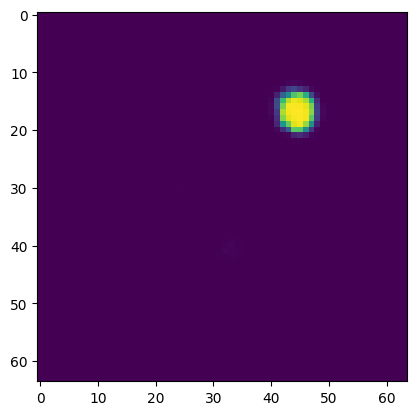

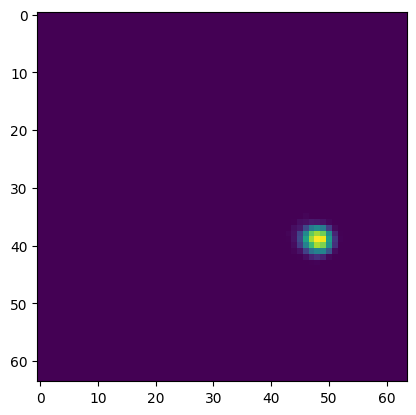

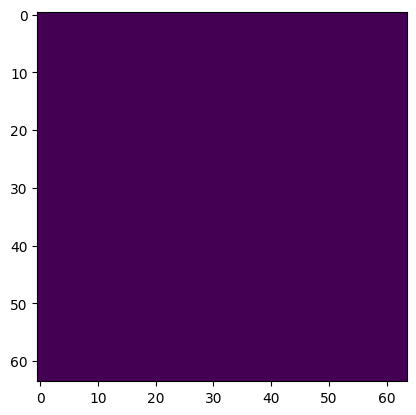

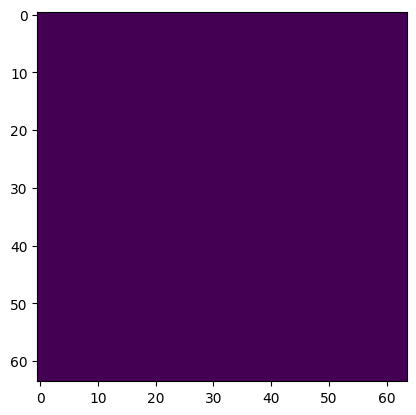

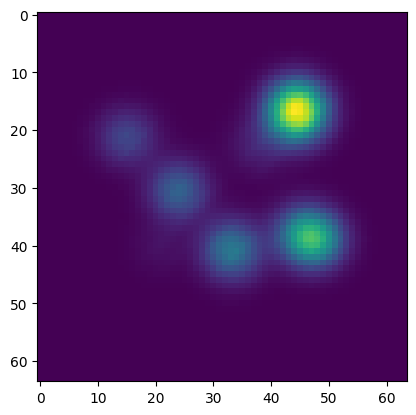

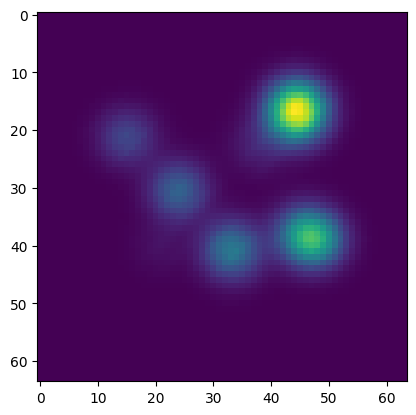

--------------------------


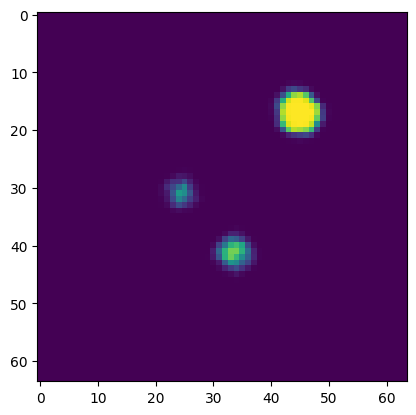

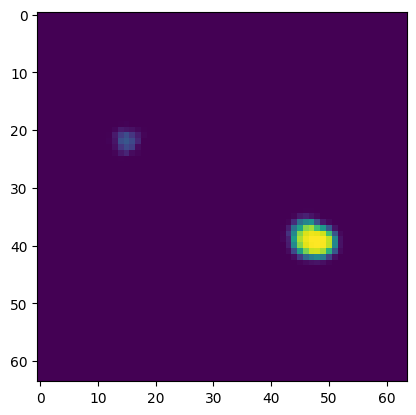

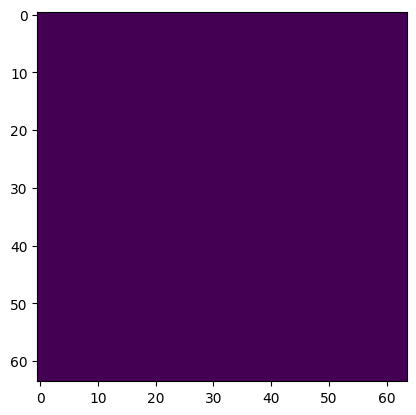

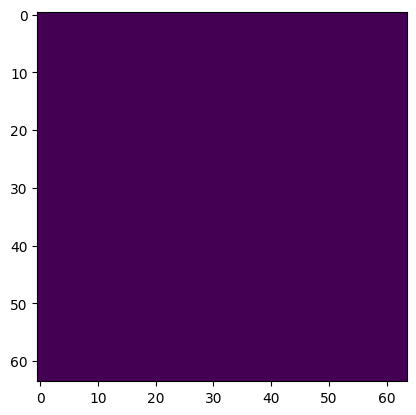

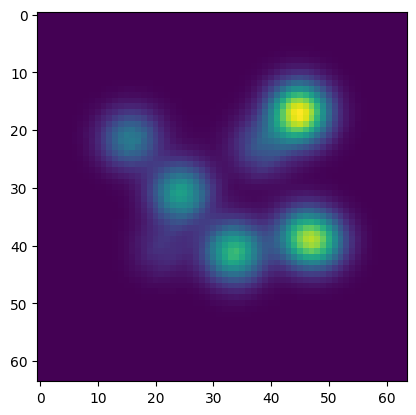

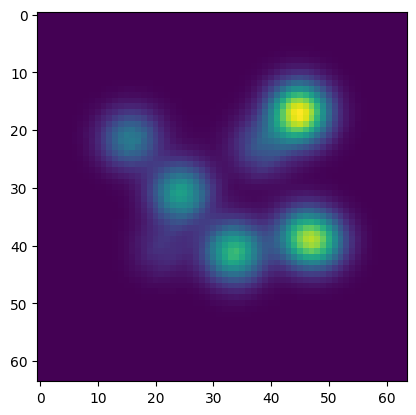

--------------------------


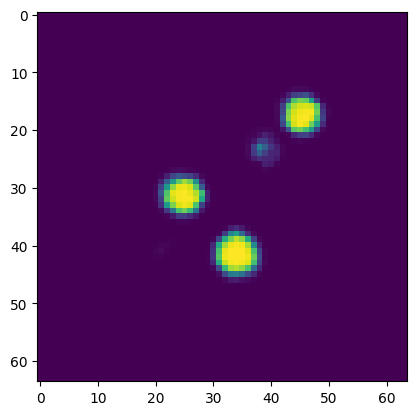

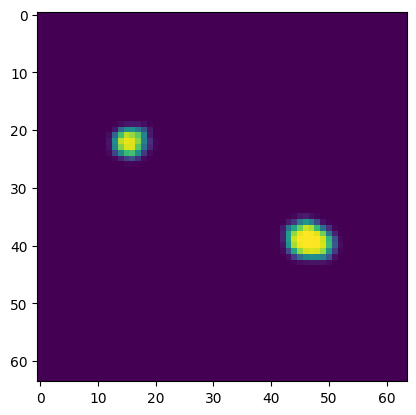

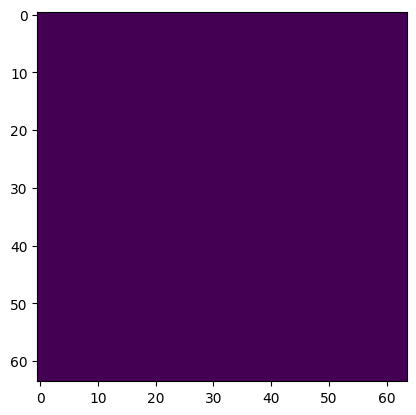

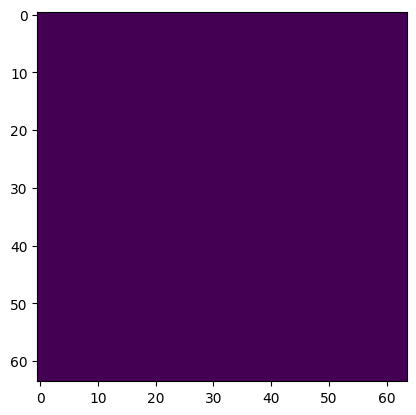

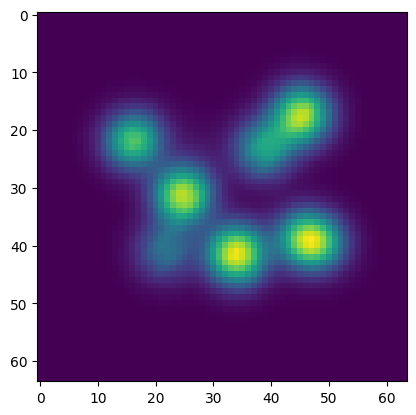

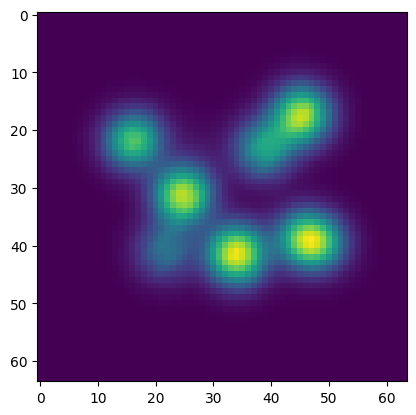

--------------------------


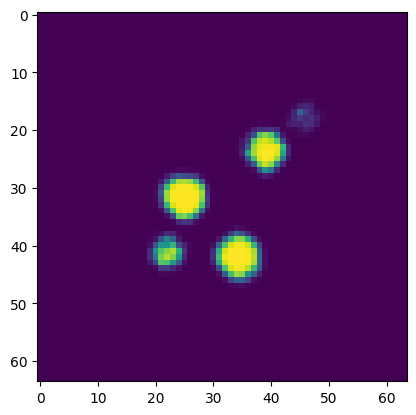

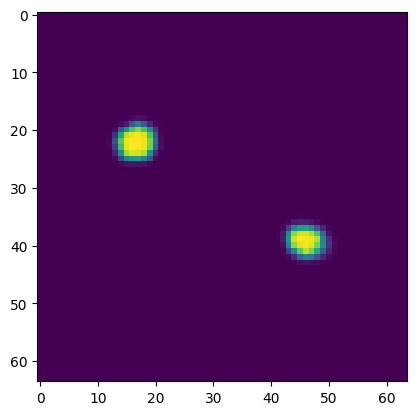

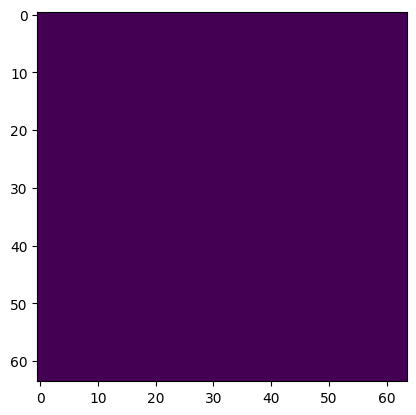

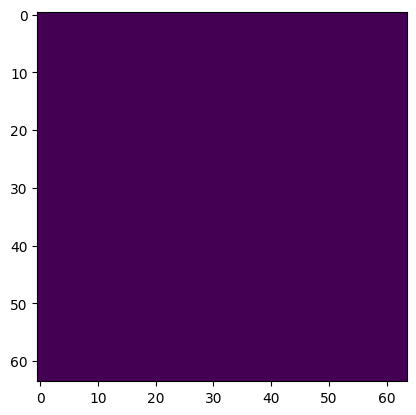

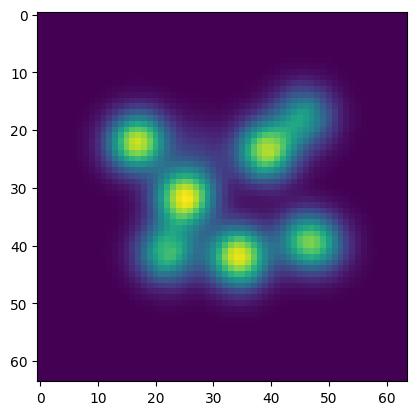

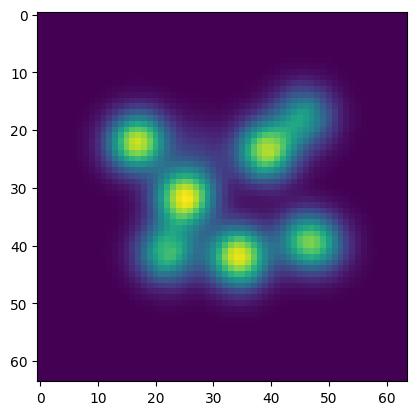

--------------------------


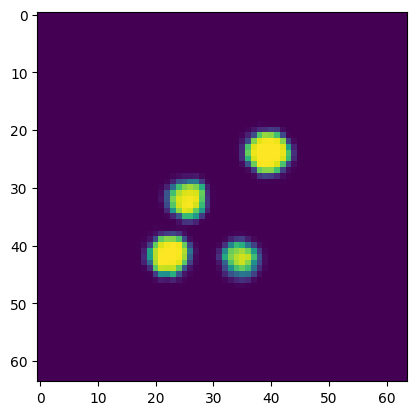

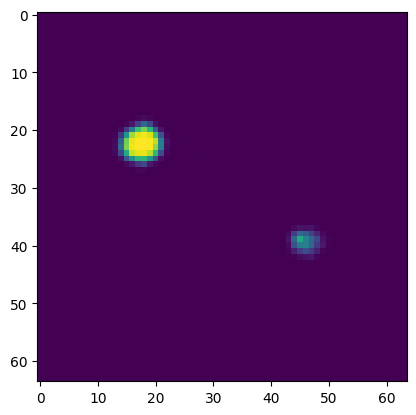

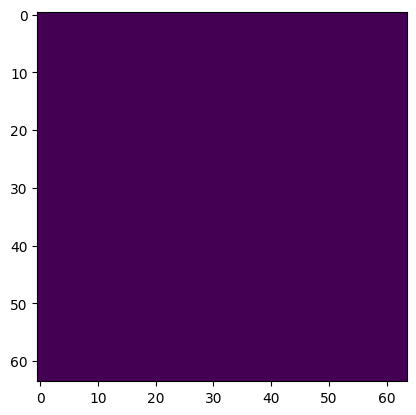

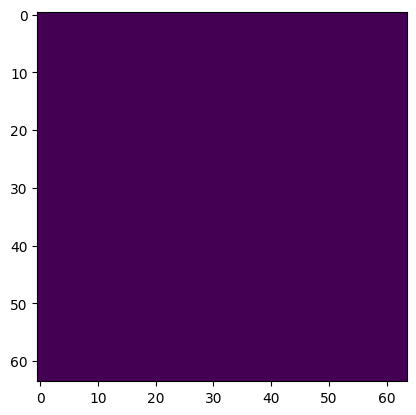

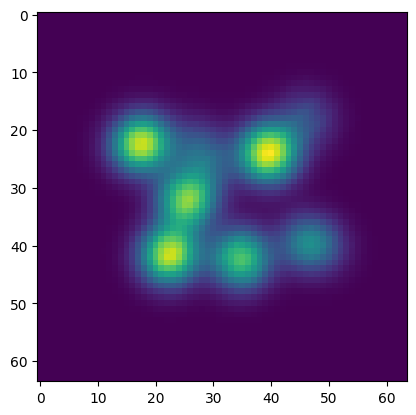

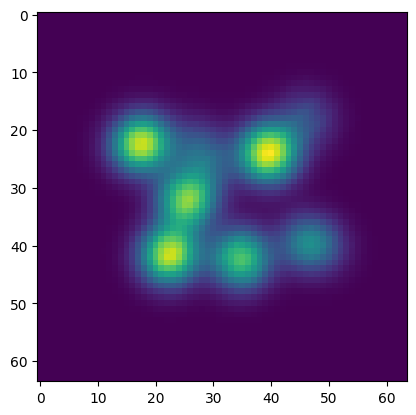

--------------------------


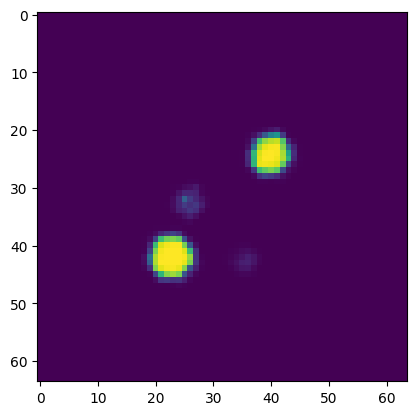

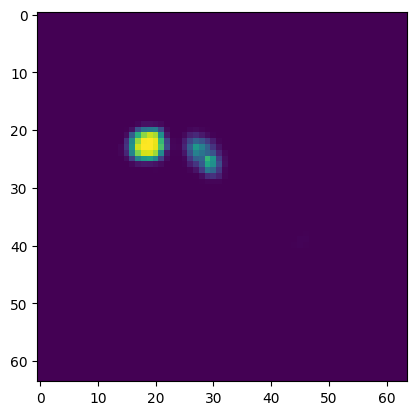

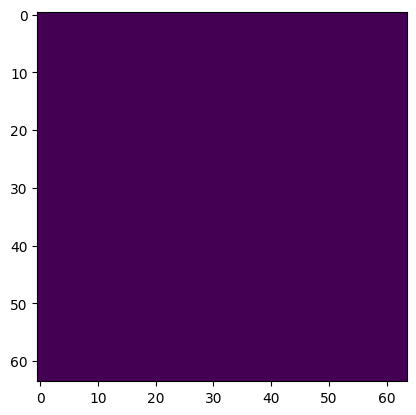

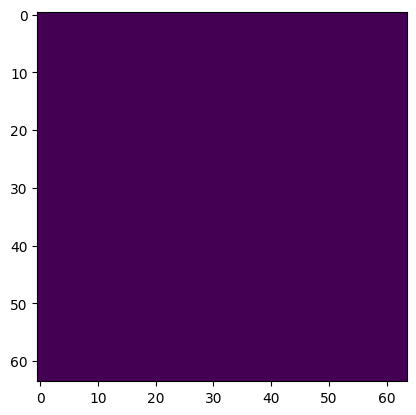

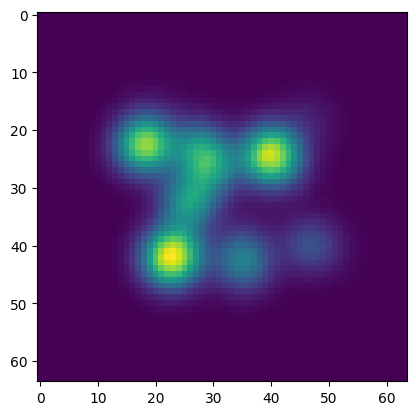

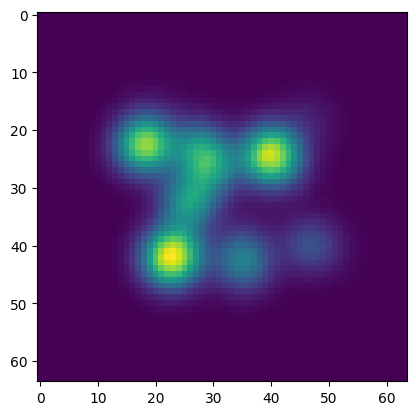

--------------------------


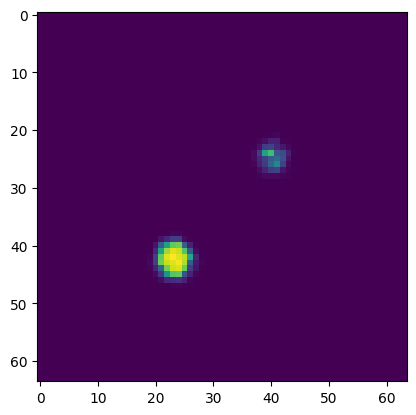

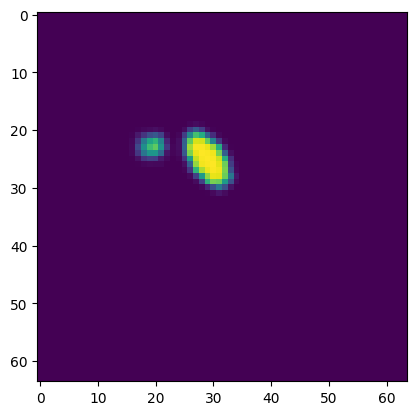

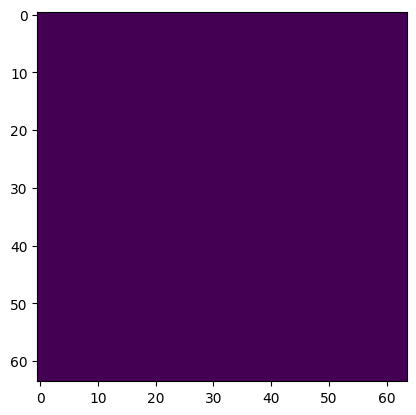

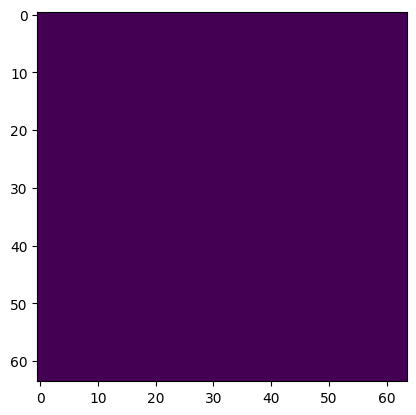

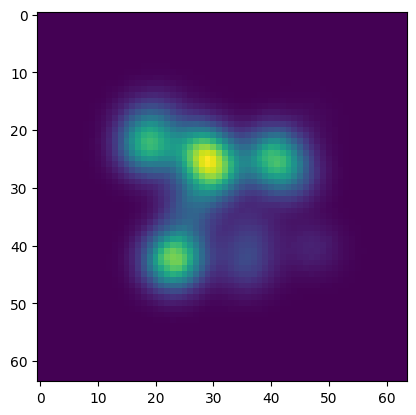

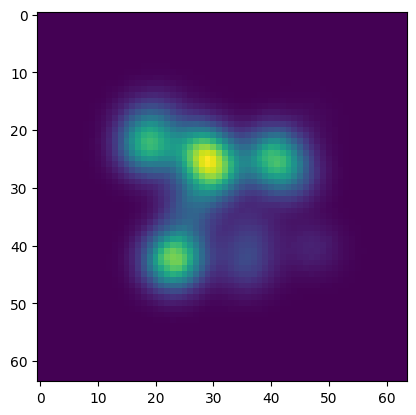

--------------------------


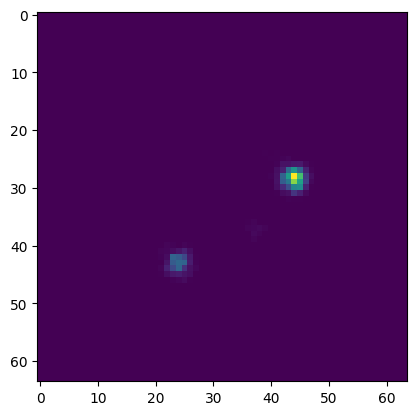

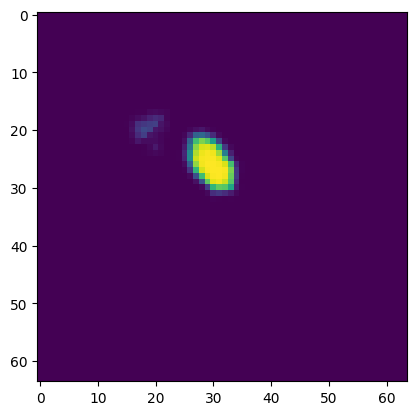

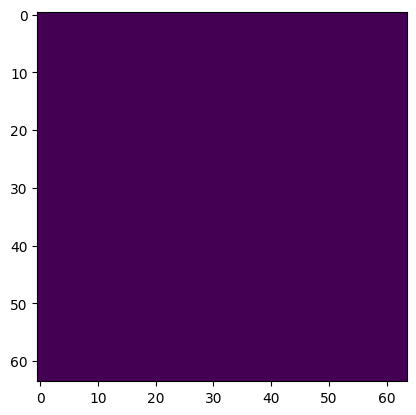

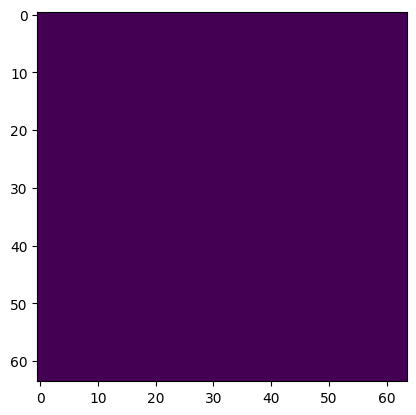

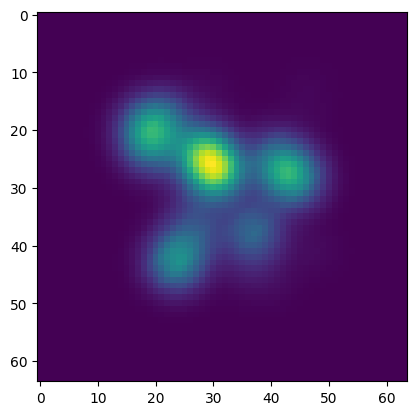

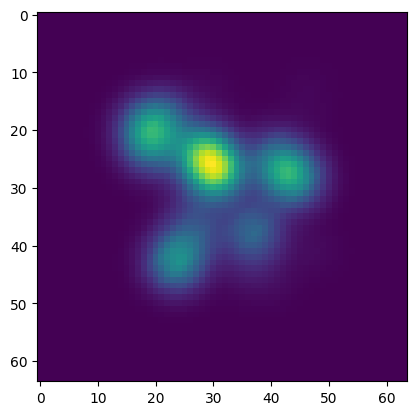

--------------------------


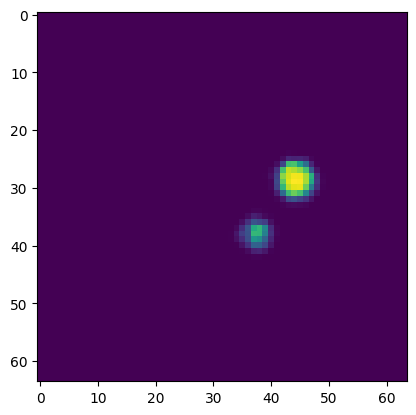

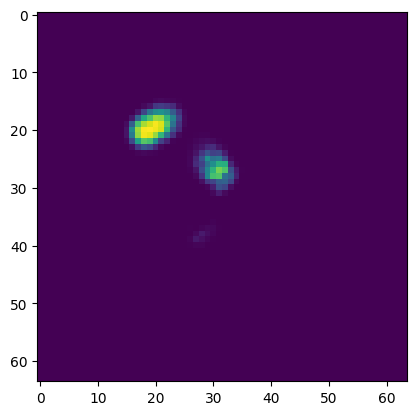

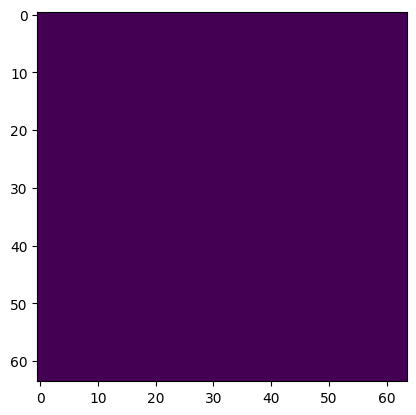

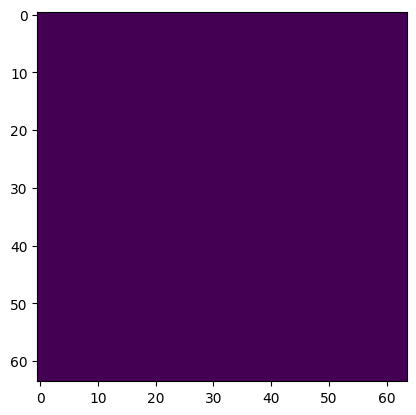

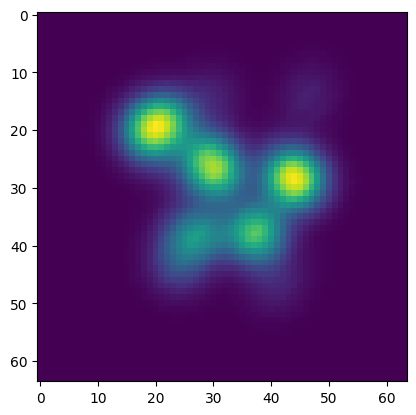

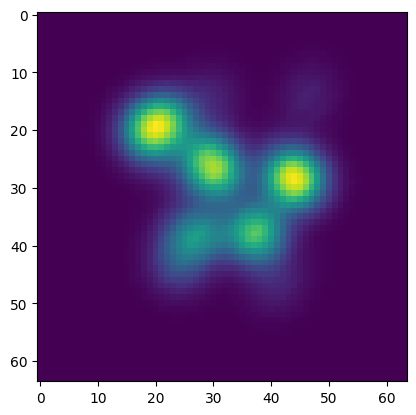

--------------------------


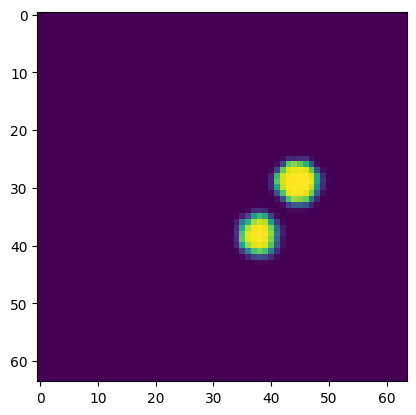

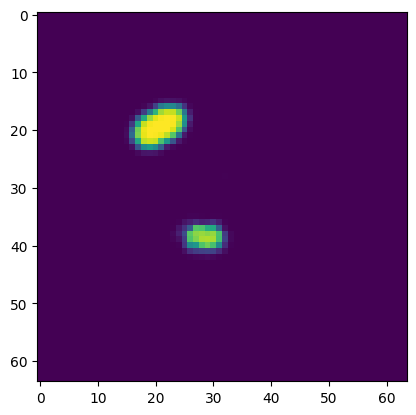

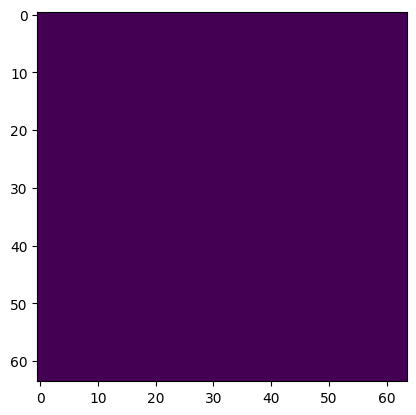

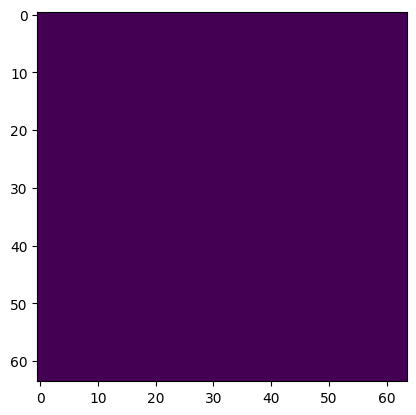

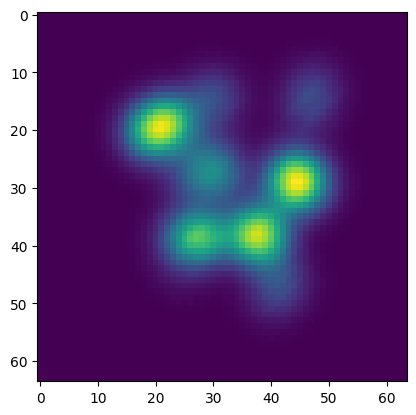

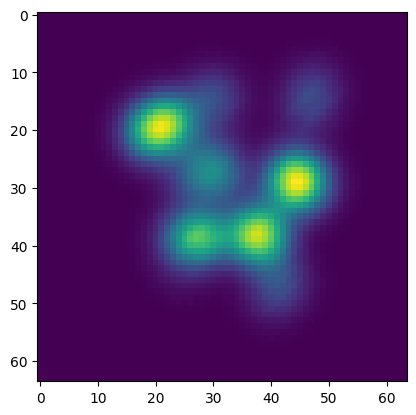

--------------------------


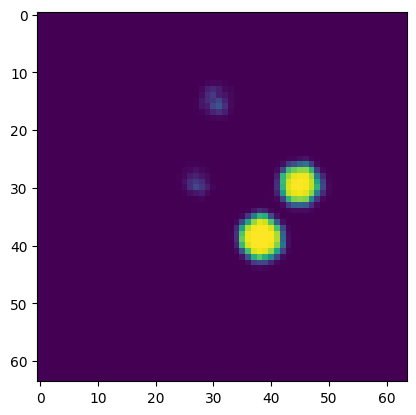

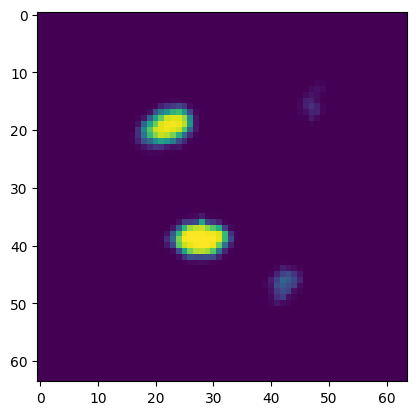

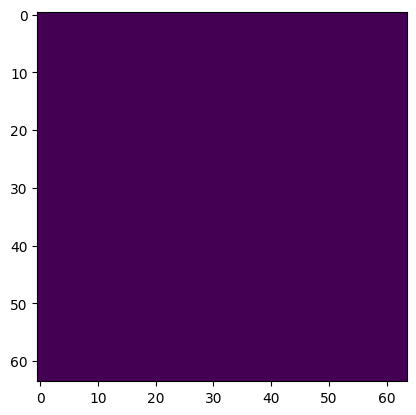

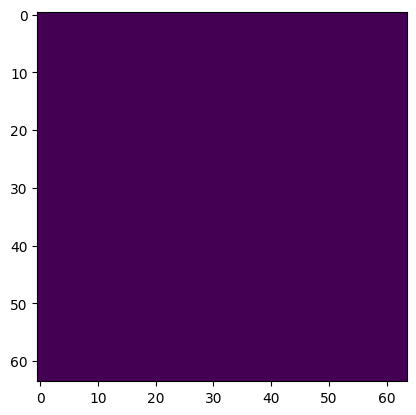

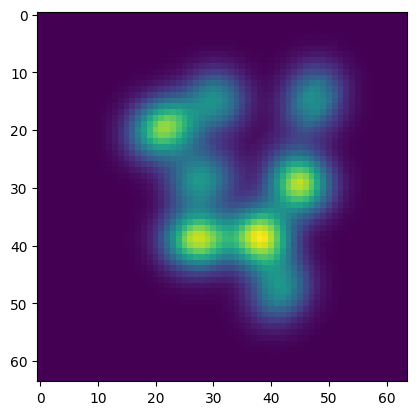

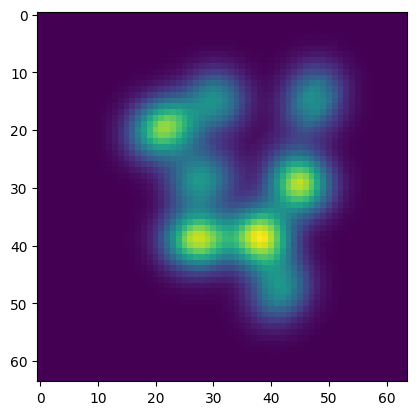

--------------------------


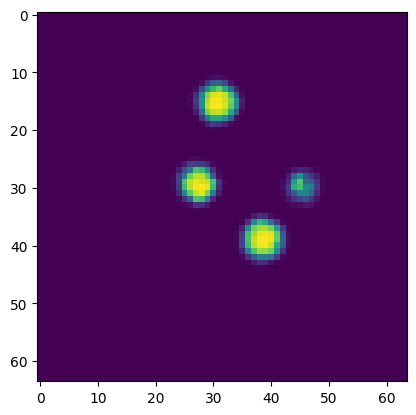

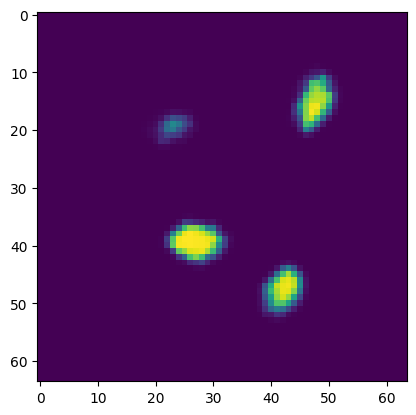

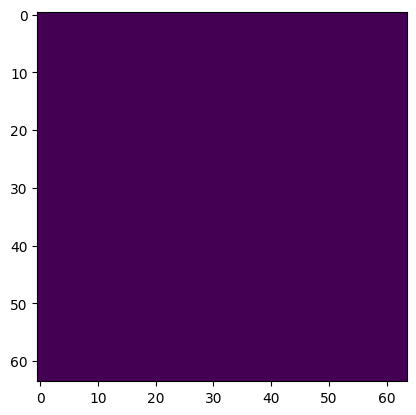

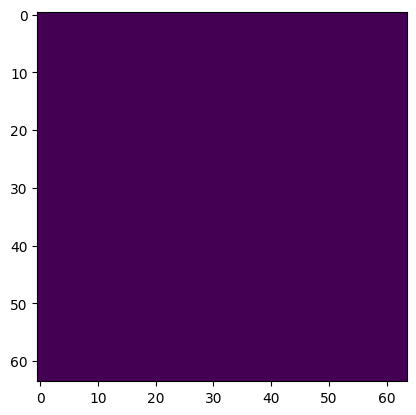

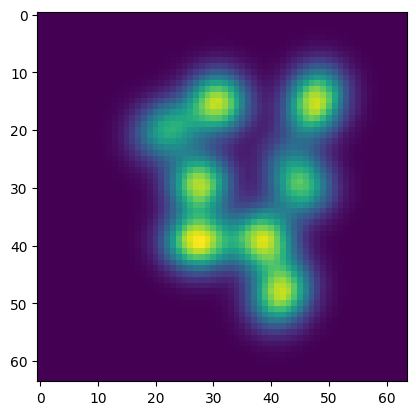

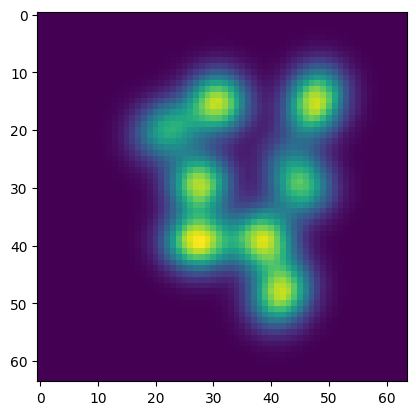

--------------------------


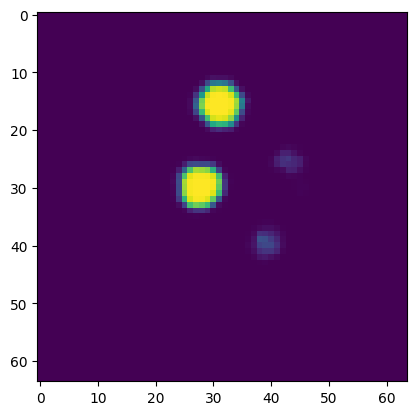

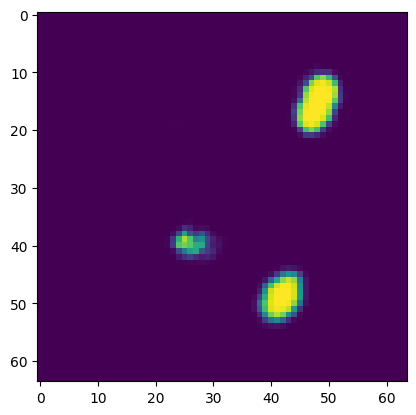

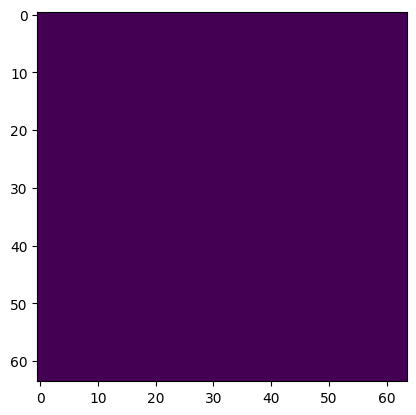

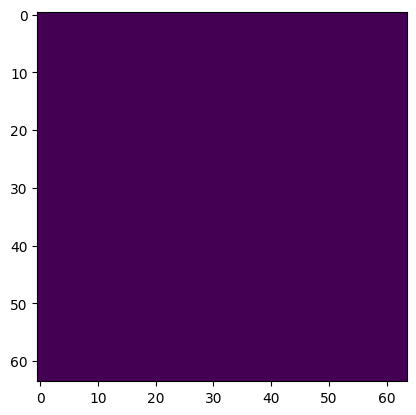

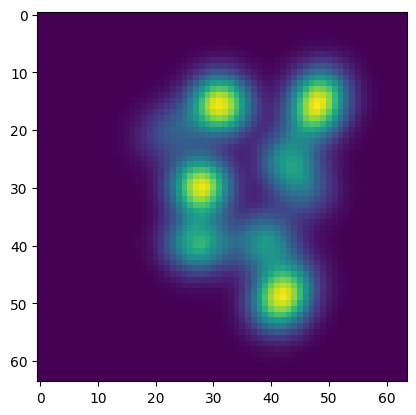

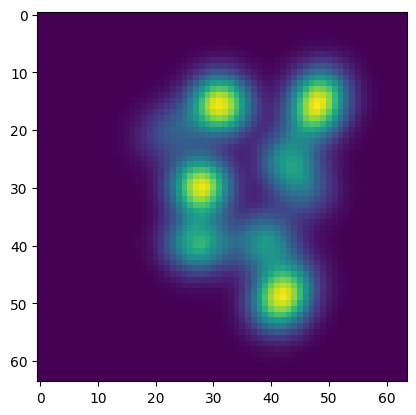

--------------------------


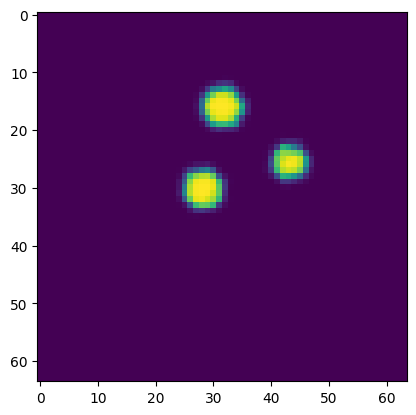

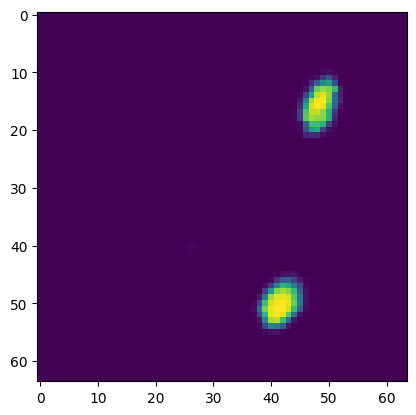

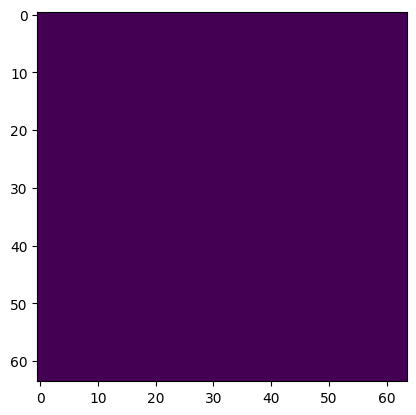

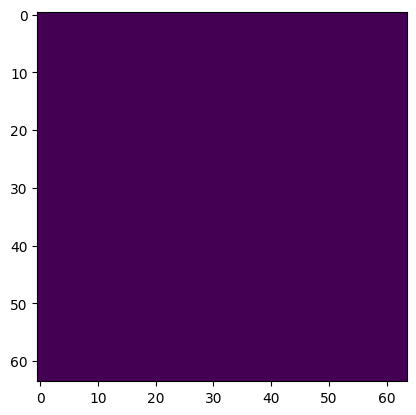

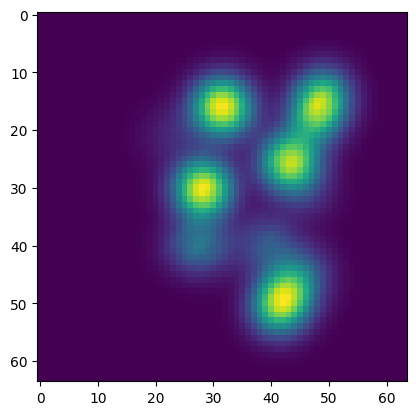

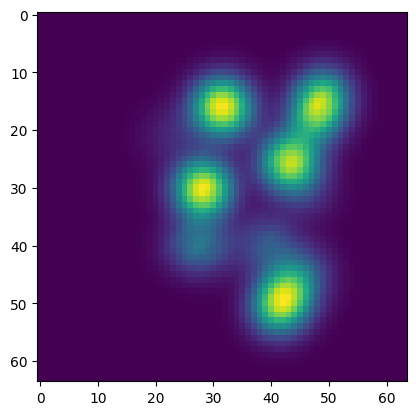

--------------------------


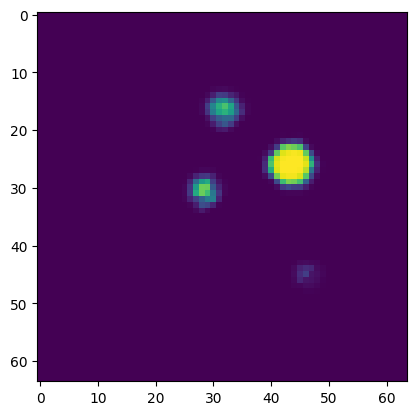

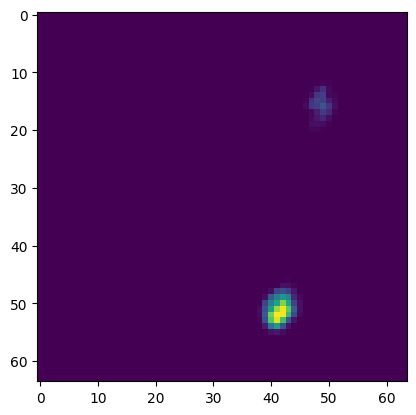

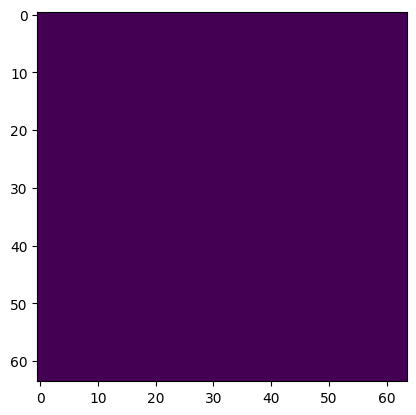

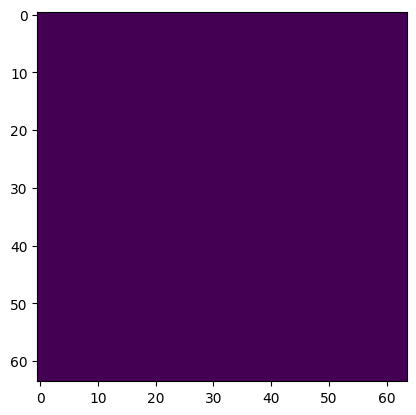

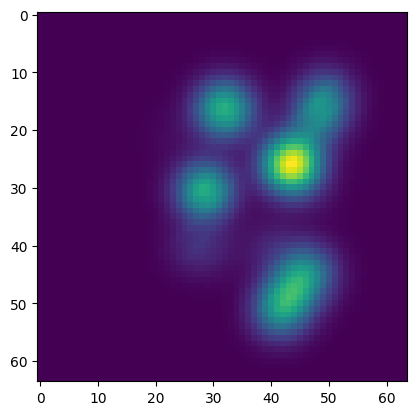

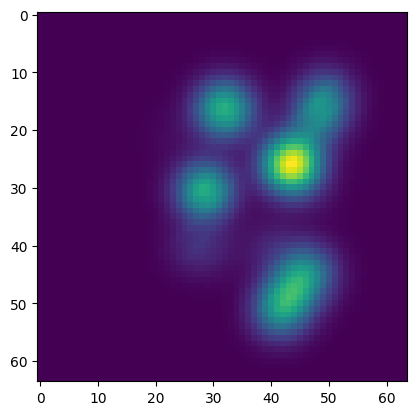

--------------------------


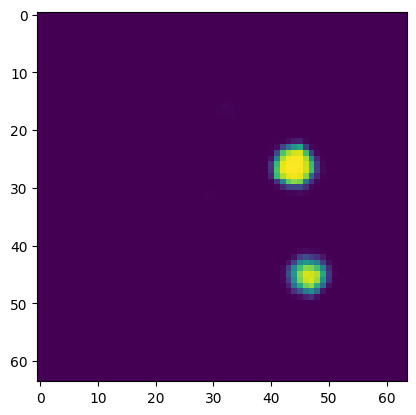

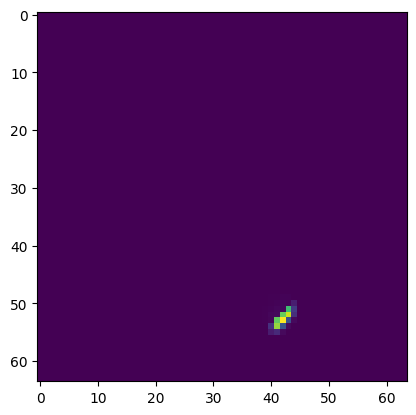

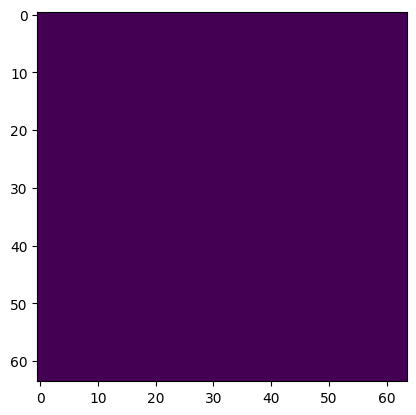

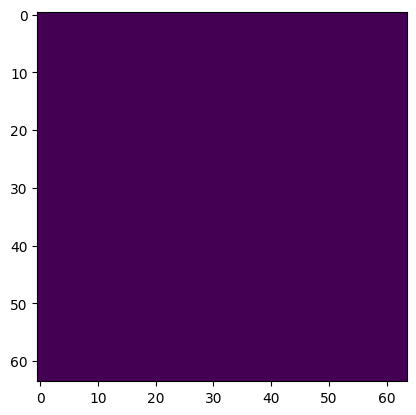

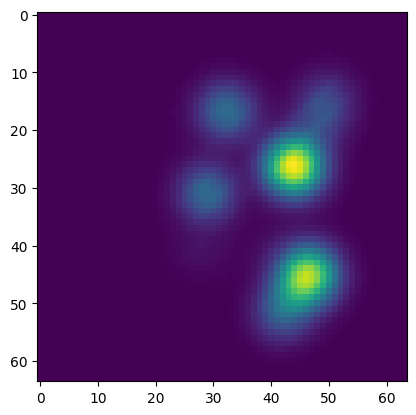

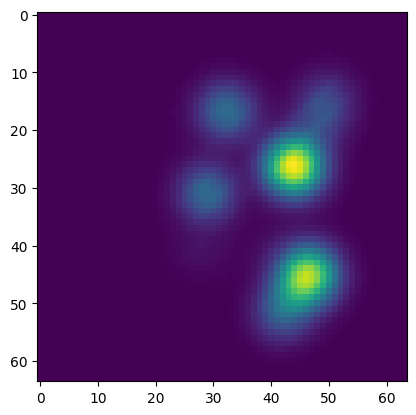

--------------------------


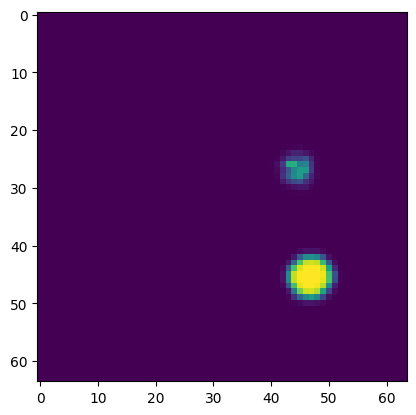

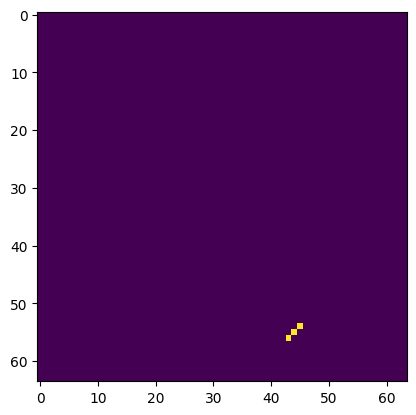

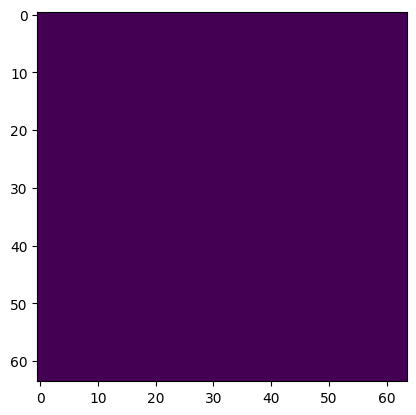

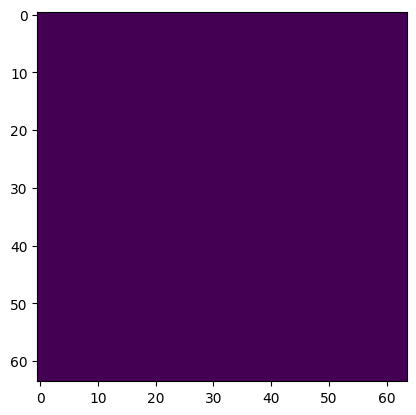

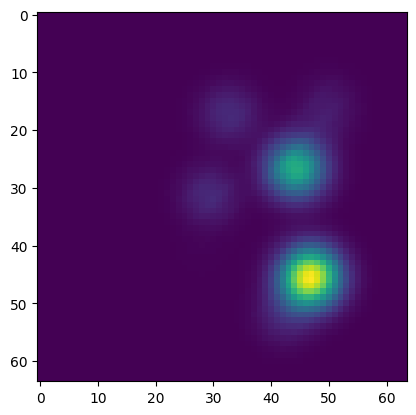

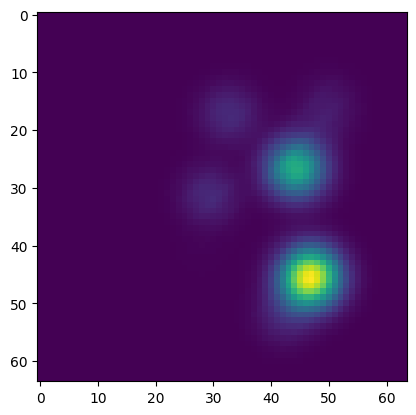

--------------------------


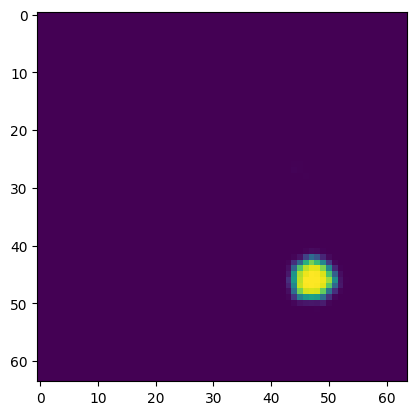

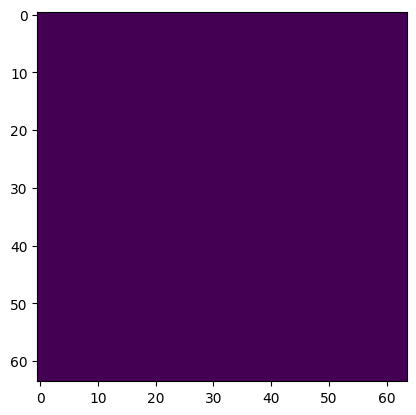

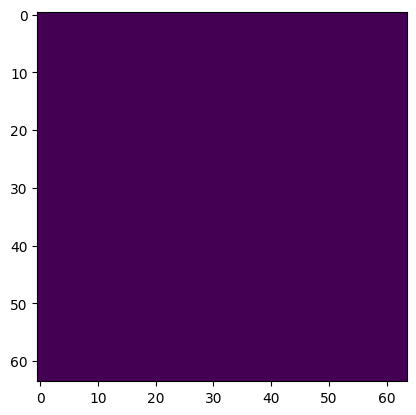

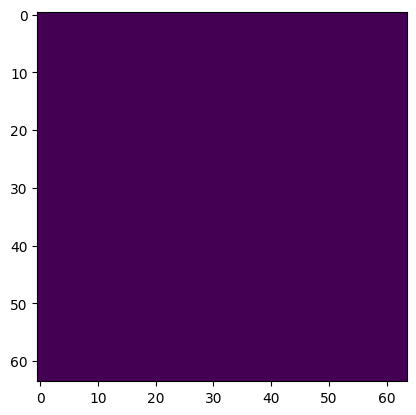

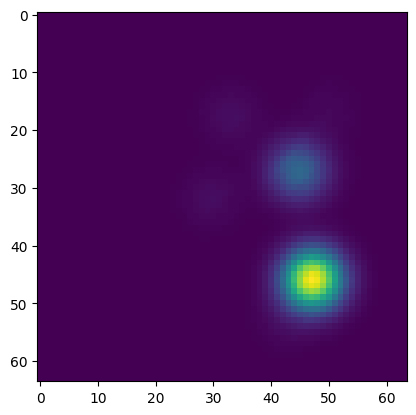

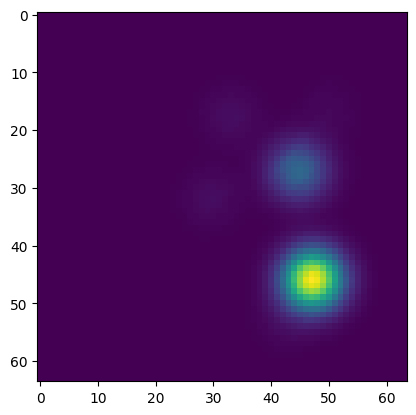

--------------------------


In [14]:
all_indices = []
all_weights = []
all_sem = []
all_xct = []
all_ref_xct = []

for loc in locations:
    normal = normal
    aligner =  embedplane.Plane3DAligner(
        normal=normal, #+delta,
        point_on_plane=[scale//2, scale//2, loc]) 
    point_on_plane_2D = (scale//2,scale//2)
    aligned_points = aligner.align_points_to_3d(UV, point_on_plane_2D, rotation_angle=0)
    
    indices, near_dist = interpolate.find_nearest(XYZ, aligned_points, 121)
    weights = interpolate.compute_weights(near_dist, power=1.0, cutoff=2.0)    
    
    sem = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices,weights)   
    sem = einops.rearrange(sem, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_sem.append(sem)
    
    for i in range(sem.shape[0]):
        plt.imshow(sem[i])
        plt.show()
        
    
    xct = interpolate.inverse_distance_weighting_with_weights_MC(flat_low_map,indices,weights)   
    xct = einops.rearrange(xct, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_xct.append(xct)
   
    plt.imshow(xct[0])
    plt.show()
    
    ref_xct = interpolate.inverse_distance_weighting_with_weights_MC(flat_xct_ref,indices,weights)   
    ref_xct = einops.rearrange(ref_xct, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_ref_xct.append(ref_xct)
   
    plt.imshow(xct[0])
    plt.show()
    
    
    print("--------------------------")
    

    
    

In [15]:
my_xct_maps = torch.concat([torch.Tensor(np.stack(all_xct))])
my_sem_maps = torch.concat([torch.Tensor(np.stack(all_sem))])

In [16]:
print(my_xct_maps.shape, my_sem_maps.shape)

torch.Size([20, 1, 64, 64]) torch.Size([20, 4, 64, 64])


In [17]:
my_data = TensorDataset(my_sem_maps, my_xct_maps)
data_loader = DataLoader(my_data, batch_size=1)

In [18]:
from fusecam.models.sem_to_xct import SemXctTransformer

In [19]:
import torch
import torch.nn as nn

class TVLoss(nn.Module):
    def __init__(self):
        super(TVLoss, self).__init__()
    
    def forward(self, img):
        # Compute the Total Variation Loss
        batch_size, _, height, width = img.size()
        tv_h = torch.abs(img[:,:,1:,:]-img[:,:,:height-1,:]).sum()
        tv_w = torch.abs(img[:,:,:,1:]-img[:,:,:,:width-1]).sum()
        return (tv_h + tv_w) / batch_size


In [20]:
net = SemXctTransformer(4,[16,16], 1.00, dropout_rate=0.0)

In [30]:
loss_function = nn.MSELoss()
smooth_loss = TVLoss()

optimizer = optim.Adam(net.parameters(), lr=0.00031)
train_scripts.train_slice_on_slice(net,
                                   loss_function,
                                   smooth_loss,
                                   optimizer,
                                   data_loader,
                                   500,
                                   0.0000001,
                                   device='cuda:0')
print()
print()

Epoch [1/500], Loss: 3.809591248682409e-05
Epoch [2/500], Loss: 3.657635199942888e-05
Epoch [3/500], Loss: 3.332193543883477e-05
Epoch [4/500], Loss: 3.675944572023582e-05
Epoch [5/500], Loss: 3.859828518670838e-05
Epoch [6/500], Loss: 3.9048440498845594e-05
Epoch [7/500], Loss: 3.5537058397494545e-05
Epoch [8/500], Loss: 3.34741504957492e-05
Epoch [9/500], Loss: 3.3938353885787366e-05
Epoch [10/500], Loss: 3.5690700565282894e-05
Epoch [11/500], Loss: 3.7539235199801625e-05
Epoch [12/500], Loss: 4.153931208747963e-05
Epoch [13/500], Loss: 4.500807585827715e-05
Epoch [14/500], Loss: 4.302335767079057e-05
Epoch [15/500], Loss: 3.701613609337073e-05
Epoch [16/500], Loss: 3.6028930526299516e-05
Epoch [17/500], Loss: 4.2363404440948214e-05
Epoch [18/500], Loss: 4.940386513681005e-05
Epoch [19/500], Loss: 4.9710372968547746e-05
Epoch [20/500], Loss: 4.5182472103988405e-05
Epoch [21/500], Loss: 4.029396770874882e-05
Epoch [22/500], Loss: 3.847026707717305e-05
Epoch [23/500], Loss: 3.989353767

Epoch [185/500], Loss: 3.172040563867995e-05
Epoch [186/500], Loss: 3.1914092778606574e-05
Epoch [187/500], Loss: 3.0221029692256707e-05
Epoch [188/500], Loss: 2.795879354380304e-05
Epoch [189/500], Loss: 2.626906112936922e-05
Epoch [190/500], Loss: 2.566398388808011e-05
Epoch [191/500], Loss: 2.6047777510029846e-05
Epoch [192/500], Loss: 2.6988619265466695e-05
Epoch [193/500], Loss: 2.7938357595758136e-05
Epoch [194/500], Loss: 2.8280909782552043e-05
Epoch [195/500], Loss: 2.8023350580497208e-05
Epoch [196/500], Loss: 2.7363388153389678e-05
Epoch [197/500], Loss: 2.6636047687134122e-05
Epoch [198/500], Loss: 2.6081163264279893e-05
Epoch [199/500], Loss: 2.612620326090109e-05
Epoch [200/500], Loss: 2.6643132162007533e-05


KeyboardInterrupt: 

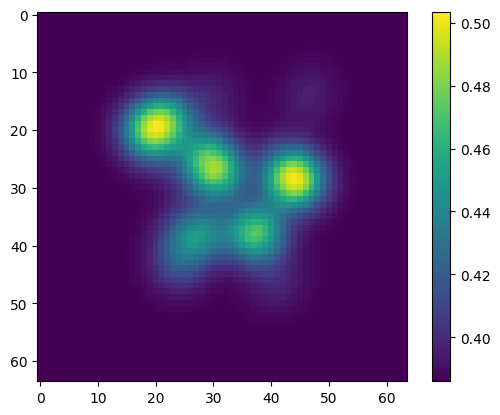

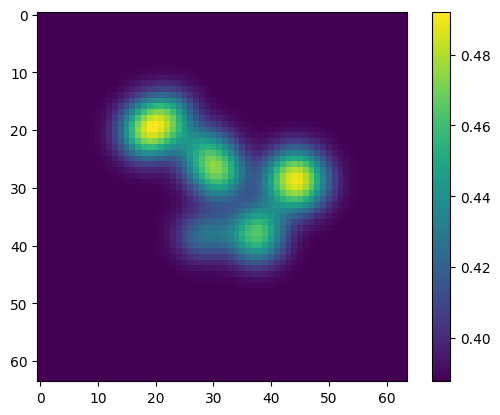

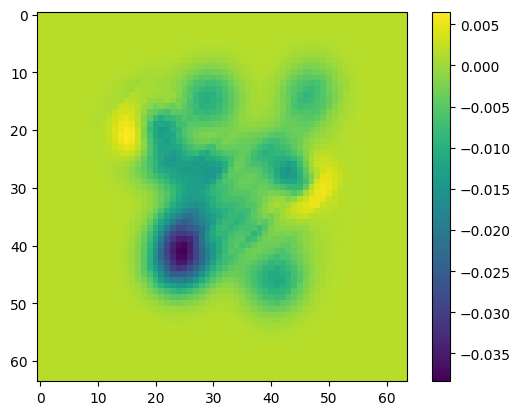

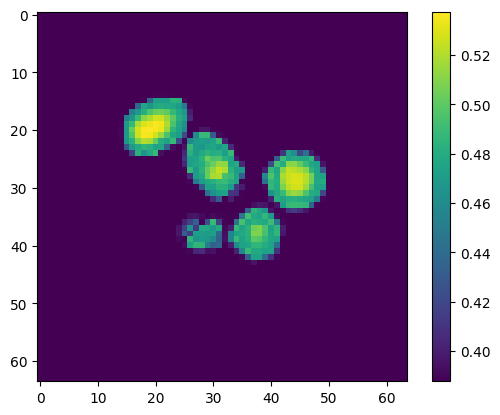

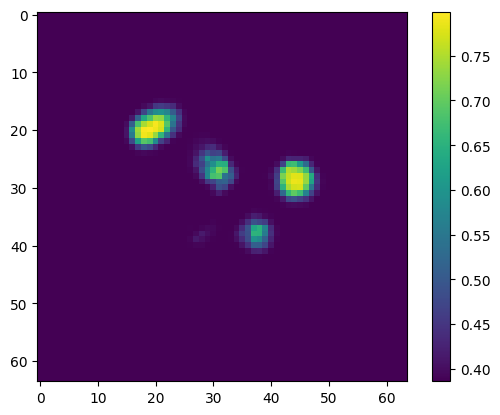

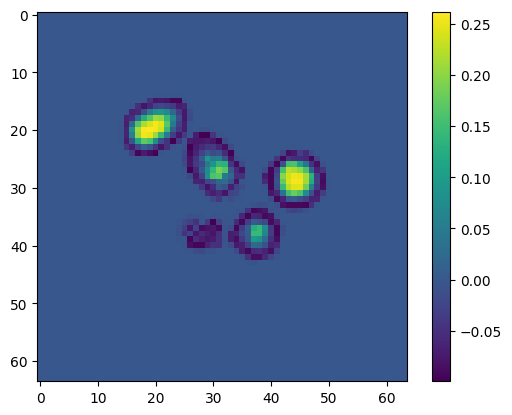

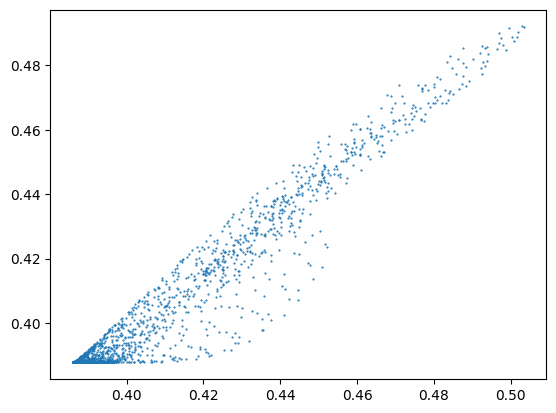

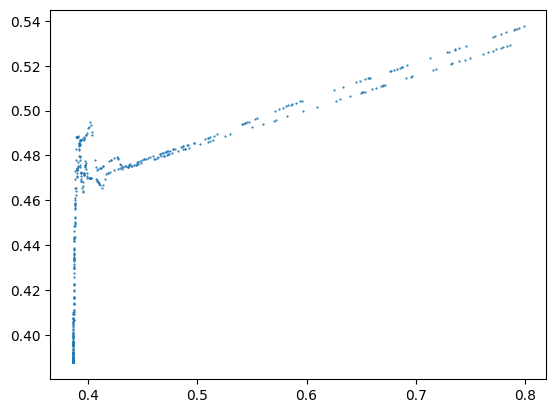

Parameter containing:
tensor([2.4567], requires_grad=True)


In [31]:
with torch.no_grad():
    plt.imshow(my_xct_maps[10,0])
    plt.colorbar()
    plt.show()
    sem, total = net.cpu()(my_sem_maps)
    sem = sem.numpy()
    total = total.numpy()
    plt.imshow(total[10,0])    
    plt.colorbar()
    plt.show()
    
    plt.imshow(total[10,0] - my_xct_maps[10,0].numpy())
    plt.colorbar()
    plt.show()
    
    
    
    plt.imshow(sem[10,0])
    plt.colorbar()
    plt.show()
    
    plt.imshow(all_ref_xct[10][0])
    plt.colorbar()
    plt.show()
  
    plt.imshow(all_ref_xct[10][0] - sem[10,0] )
    plt.colorbar()
    plt.show()
    

    plt.plot(my_xct_maps[10,0].numpy().flatten(), total[10,0].flatten(),'.', markersize=1.1)
    plt.show()
    
    plt.plot(all_ref_xct[10][0].flatten(), sem[10,0].flatten(), '.', markersize=1.1)
    plt.show()
    print(net.blur_object.sigma)
    
 
    #part1 = net.sem_tomo_projector()